### Setup of the UniverSeg environment

In [1]:
!git clone https://github.com/JJGO/UniverSeg
!python -m pip install -r ./UniverSeg/requirements.txt

Cloning into 'UniverSeg'...


In [46]:
import math
import itertools

from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

import einops as E

import pathlib
import os
import subprocess
from dataclasses import dataclass
from typing import Literal, Optional, Tuple
from torch.utils.data import Dataset
import PIL
from PIL import Image
import matplotlib.pyplot as plt

In [47]:
import sys
sys.path.append('UniverSeg')

import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

from universeg import universeg
model = universeg(pretrained=True)
_ = model.to(device)

cpu


### Define folders Eveline

In [48]:
#Training input images
support_input_folder = "C:\\Users\\eveli\\OneDrive\\Documenten\\GitHub\\Thesis-EvelineKleijne\\Original data\\Training\\training_input"
#Training without papillary muscle
support_output_nonpap_folder ="C:\\Users\\eveli\\OneDrive\\Documenten\\GitHub\\Thesis-EvelineKleijne\\Original data\\Training\\training_withoutpap"
#Training with papillary muscle
support_output_pap_folder ="C:\\Users\\eveli\\OneDrive\\Documenten\\GitHub\\Thesis-EvelineKleijne\\Original data\\Training\\training_withpap"

#Test input images
test_input_folder = "C:\\Users\\eveli\\OneDrive\\Documenten\\GitHub\\Thesis-EvelineKleijne\\Original data\\test_input"
#Test without papillary muscle
test_output_nonpap_folder = "C:\\Users\\eveli\\OneDrive\\Documenten\\GitHub\\Thesis-EvelineKleijne\\Original data\\test_withoutpap"
#Test with papillary muscle
test_output_pap_folder = "C:\\Users\\eveli\\OneDrive\\Documenten\\GitHub\\Thesis-EvelineKleijne\\Original data\\test_withpap"

### Help functions of UniverSeg

In [49]:
def visualize_tensors(tensors, col_wrap=8, col_names=None, title=None):
    M = len(tensors)
    N = len(next(iter(tensors.values())))

    cols = col_wrap
    rows = math.ceil(N/cols) * M

    d = 2.5
    fig, axes = plt.subplots(rows, cols, figsize=(d*cols, d*rows))
    if rows == 1:
      axes = axes.reshape(1, cols)

    for g, (grp, tensors) in enumerate(tensors.items()):
        for k, tensor in enumerate(tensors):
            col = k % cols
            row = g + M*(k//cols)
            x = tensor.detach().cpu().numpy().squeeze()
            ax = axes[row,col]
            if len(x.shape) == 2:
                ax.imshow(x,vmin=0, vmax=1, cmap='gray')
            else:
                ax.imshow(E.rearrange(x,'C H W -> H W C'))
            if col == 0:
                ax.set_ylabel(grp, fontsize=16)
            if col_names is not None and row == 0:
                ax.set_title(col_names[col])

    for i in range(rows):
        for j in range(cols):
            ax = axes[i,j]
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])

    if title:
        plt.suptitle(title, fontsize=20)

    plt.tight_layout()

### Formatting our input to the UniverSeg model
This is done by rewriting the wbc.py file which was specificly for the WBC dataset to a function which can read the dog dataset.

In [50]:
def process_image(path: pathlib.Path, size: Tuple[int, int]) -> np.ndarray:
    """Process input image."""
    img = PIL.Image.open(path)
    img = img.resize(size, resample=PIL.Image.BILINEAR)
    img = img.convert("L")  # Convert image to grayscale
    img = np.array(img, dtype=np.float32)
    return img 

def process_segmentation(path: pathlib.Path, size: Tuple[int, int]) -> np.ndarray:
    """Process segmentation mask."""
    seg = PIL.Image.open(path)
    seg = seg.resize(size, resample=PIL.Image.NEAREST)
    seg = np.array(seg)
    seg = np.expand_dims(seg == 255, axis=0)
    return seg.astype(np.float32)

def load_dataset(input_folder: str, label: str = None, size: Tuple[int, int] = (128, 128)):
    """Load dataset from folder with optional custom segmentation mask."""
    data = []
    input_path = pathlib.Path(input_folder)
    label_path = pathlib.Path(label) if label else None
    count = 1
    for file in sorted(input_path.glob("*.png")):
        img = process_image(file, size=size)
        

        # If label folder is provided, use the segmentation mask, otherwise, use None
        seg = None
        if label_path:
            seg_file = label_path / f"Segment{count:05}.png"
            if seg_file.exists():
                seg = process_segmentation(seg_file, size=size)
            else:
                print(f"Segmentation mask file '{seg_file}' not found. Skipping.")
        
        data.append((img / 256.0, seg))
        count+=1

    return data


class VentricleDataset(Dataset):
    def __init__(self, input_folder: str, label: str = None, size: Tuple[int, int] = (128, 128)):
        self.data = load_dataset(input_folder, label, size=size)
        T = torch.from_numpy
        self.data = [(T(x)[None], T(y)) for x, y in self.data]
        self.idxs = list(range(len(self.data)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_img, seg = self.data[self.idxs[idx]]
        return input_img, seg

### Inference on unseen tasks

In [51]:
d_support = VentricleDataset(support_input_folder, label=support_output_nonpap_folder)
d_test = VentricleDataset(test_input_folder, label=test_output_nonpap_folder)
#d_support = VentricleDataset(support_input_folder, label=support_output_pap_folder) For the pap masks change later
#d_test = VentricleDataset(test_input_folder, label=test_output_pap_folder)

n_support = 16

support_images, support_labels = zip(*itertools.islice(d_support, n_support))
 
# # Use torch.stack() to stack tensors
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)

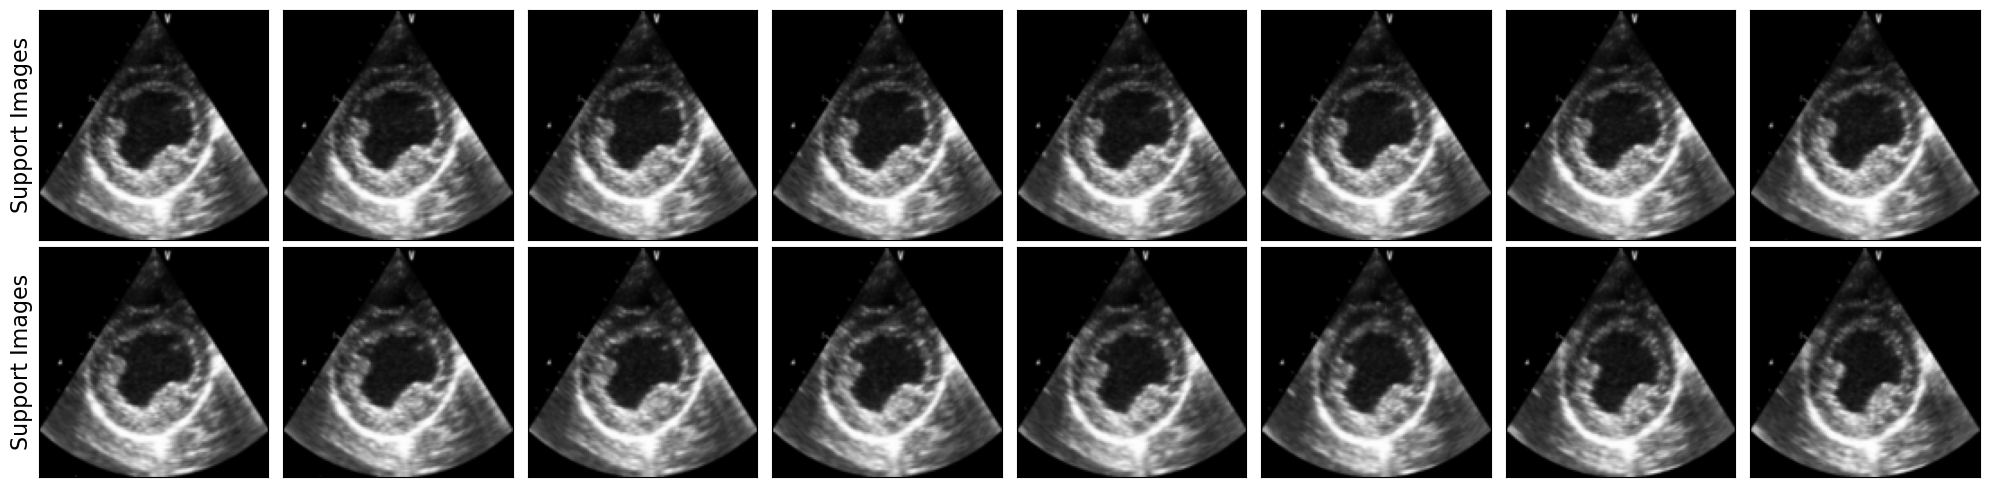

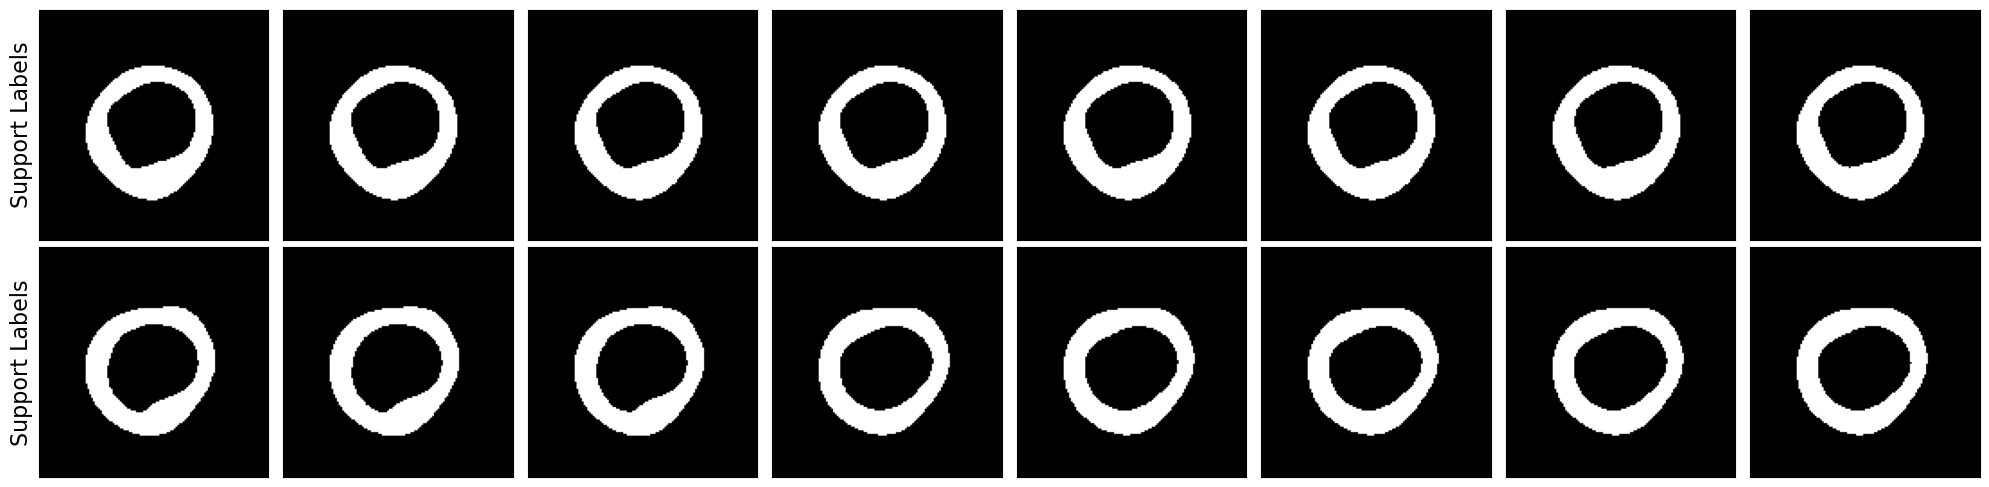

In [52]:
# Visualize support images
visualize_tensors({'Support Images': support_images})

# Visualize support labels
visualize_tensors({'Support Labels': support_labels})

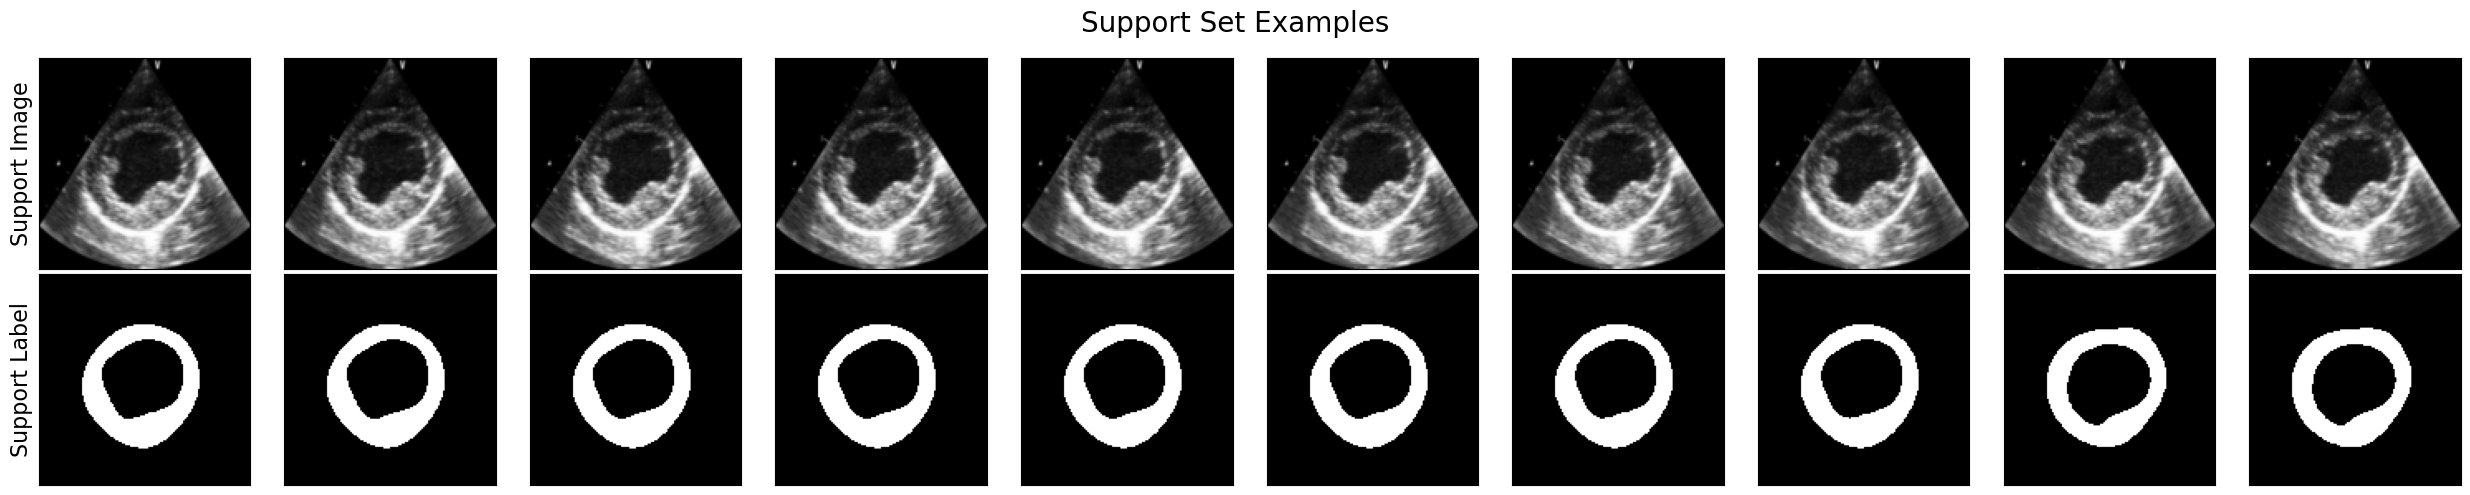

In [53]:
n_viz = 10
visualize_tensors({
    'Support Image': support_images[:n_viz],
    'Support Label': support_labels[:n_viz],
}, col_wrap=10, title='Support Set Examples')

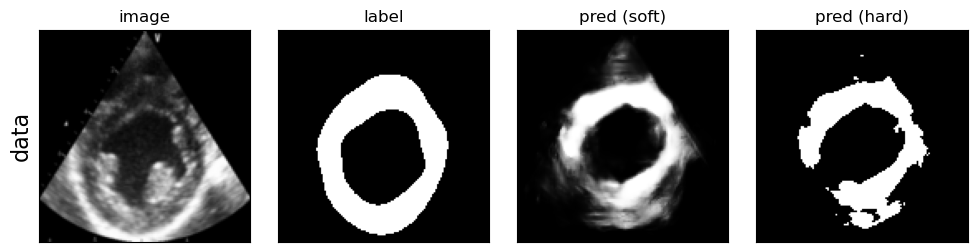

In [54]:
# select an image, label test pair
idx = np.random.permutation(len(d_test))[0]
image, label = d_test[idx]
image, label = image.to(device), label.to(device)

# run inference
logits = model(image[None], support_images[None], support_labels[None])[0].to('cpu')
pred = torch.sigmoid(logits)

# visualize
res = {'data': [image, label, pred, pred > 0.5]}
titles = col_names=['image', 'label', 'pred (soft)', 'pred (hard)']
visualize_tensors(res, col_wrap=4, col_names=titles)

### Inference Analysis

In [55]:
# Dice metric for measuring volume agreement
def dice_score(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    y_pred = y_pred.long()
    y_true = y_true.long()
    score = 2*(y_pred*y_true).sum() / (y_pred.sum() + y_true.sum())
    return score.item()

The following metrics are implemented as an extra way to validate and evaluate the UniverSeg model :

In [70]:
#Accuracy score implemented
def accuracy_score(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    y_pred = y_pred.long()
    y_true = y_true.long()
    correct = (y_pred == y_true).sum().item()
    total = y_true.numel()
    accuracy = correct / total
    
    return accuracy

In [71]:
def sensitivity_score(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    y_pred = y_pred.long()
    y_true = y_true.long()
    true_positives = ((y_pred == 1) & (y_true == 1)).sum().item()
    false_negatives = ((y_pred == 0) & (y_true == 1)).sum().item()
    sensitivity = true_positives / (true_positives + false_negatives) if true_positives + false_negatives != 0 else 0

    return sensitivity

In [72]:
def precision_score(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    y_pred = y_pred.long()
    y_true = y_true.long()
    true_positives = ((y_pred == 1) & (y_true == 1)).sum().item()
    false_positives = ((y_pred == 1) & (y_true == 0)).sum().item()
    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives != 0 else 0

    return precision

Jaccard similarity, also known as the Jaccard index or Jaccard coefficient, measures the similarity between two sets by comparing their intersection to their union. In the context of binary classification, the Jaccard score can be computed as the intersection of the predicted positive instances and the true positive instances divided by the union of the predicted positive instances and the true positive instances.

In [73]:
def jaccard_score(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    y_pred = y_pred.long()
    y_true = y_true.long()
    intersection = ((y_pred == 1) & (y_true == 1)).sum().item()
    union = ((y_pred == 1) | (y_true == 1)).sum().item()
    jaccard = intersection / union if union != 0 else 0

    return jaccard

In [85]:
# run inference and compute losses for one test image
@torch.no_grad()
def inference(model, image, label, support_images, support_labels):
    image, label = image.to(device), label.to(device)

    # inference
    logits = model(
        image[None],
        support_images[None],
        support_labels[None]
    )[0] # outputs are logits

    soft_pred = torch.sigmoid(logits)
    hard_pred = soft_pred.round().clip(0,1)

    #  score
    dicescore = dice_score(hard_pred, label)

    # return a dictionary of all relevant variables
    return {'Image': image,
            'Soft Prediction': soft_pred,
            'Prediction': hard_pred,
            'Ground Truth': label,
            'score': dicescore}

  0%|          | 0/10 [00:00<?, ?it/s]

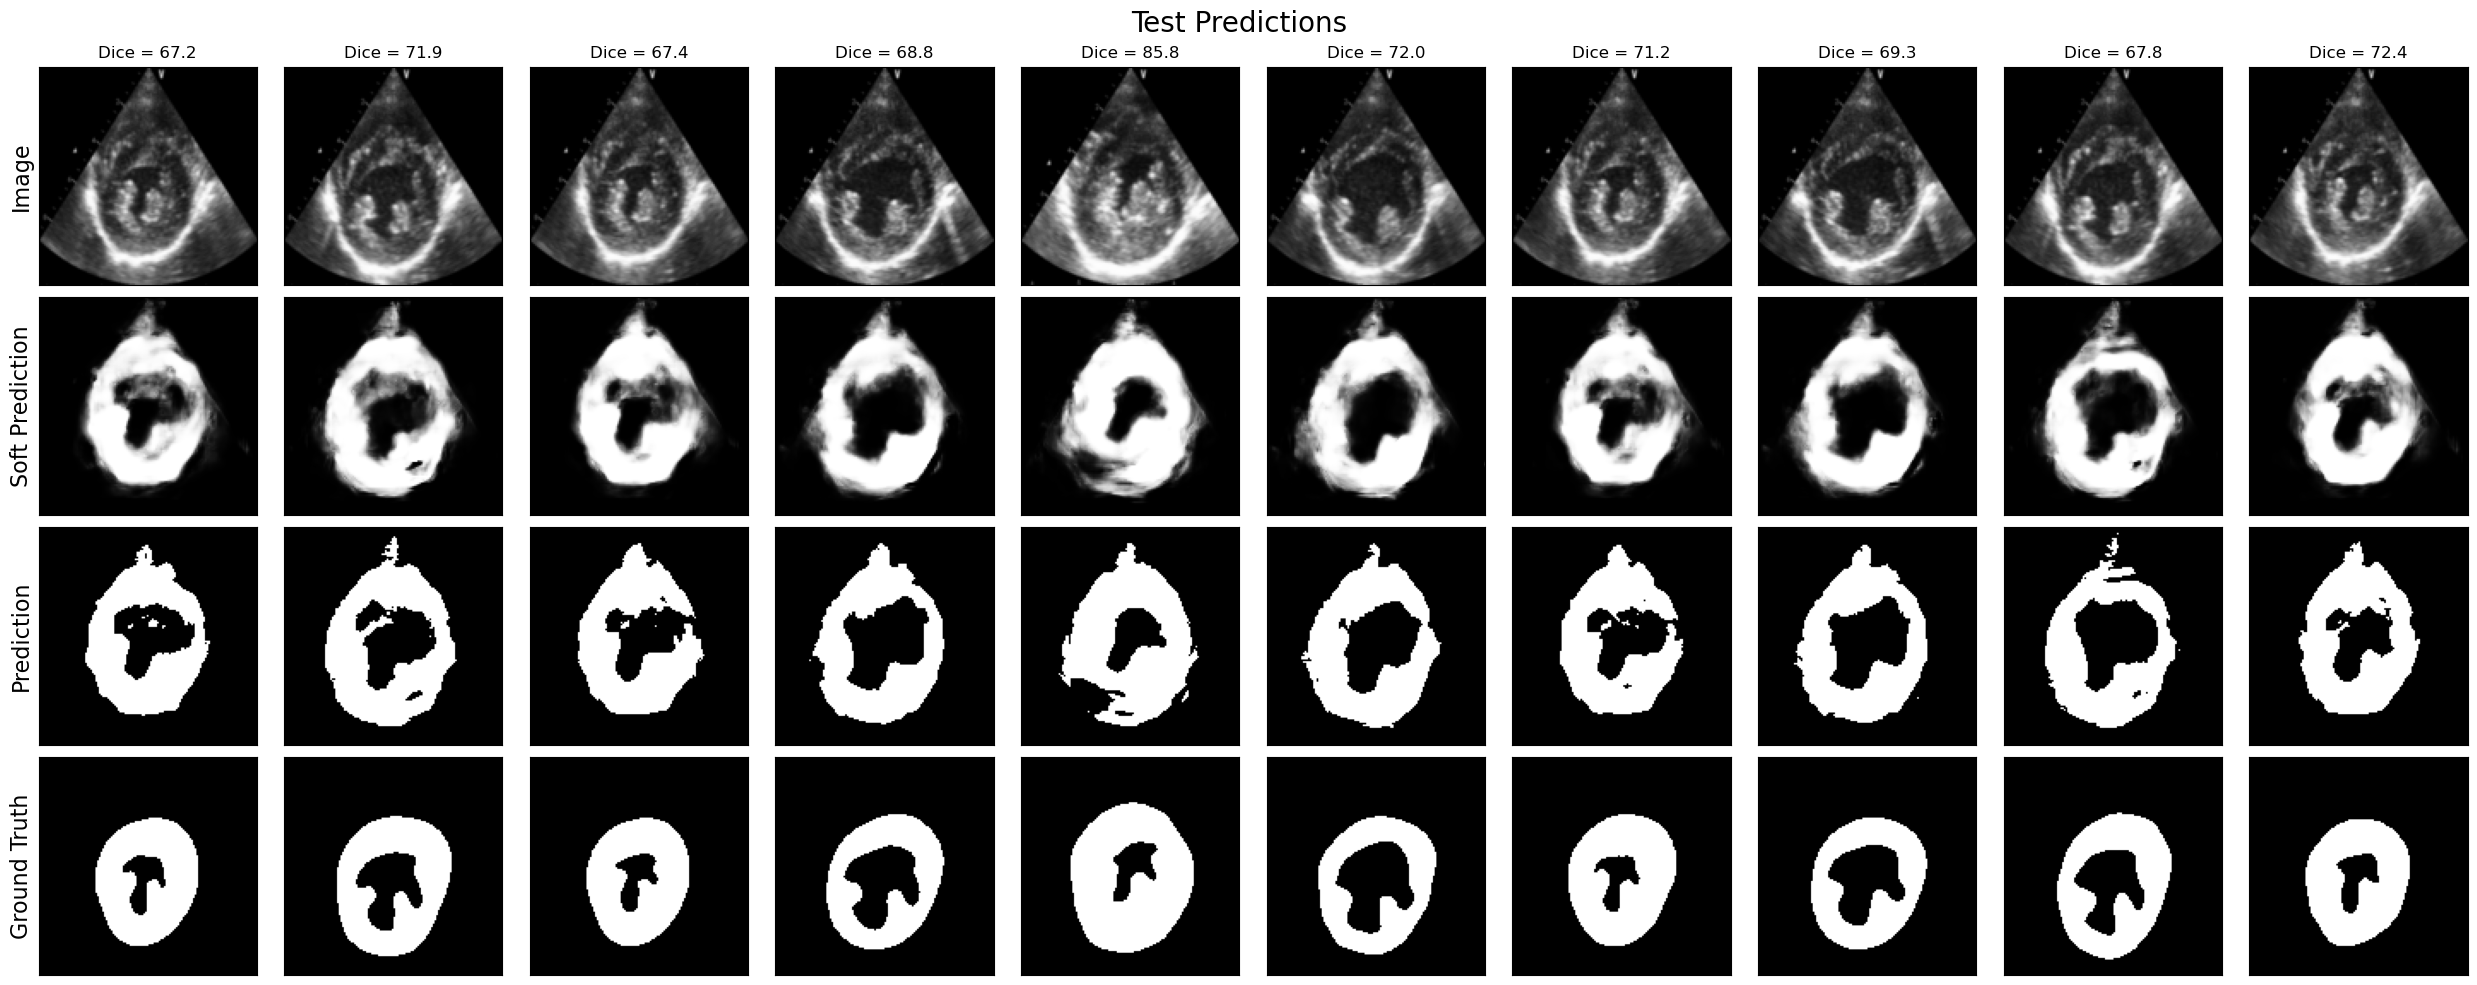

In [86]:
from collections import defaultdict

n_predictions = 10

results = defaultdict(list)

# compute inference and save predictions and metrics for n_predictions
idxs = np.random.permutation(len(d_test))[:n_predictions]

for i in tqdm(idxs):
    image, label = d_test[i]
    vals = inference(model, image, label, support_images, support_labels)
    for k, v in vals.items():
        results[k].append(v)

# visualize the results, along with their scores
scores = results.pop('score')
visualize_tensors(results,
                  col_names=[f'Dice = {100*s:.1f}' for s in scores],
                  title='Test Predictions',
                  col_wrap=n_predictions)

### Support labels

In [59]:
n_support = 64

In [60]:
d_support = VentricleDataset(support_input_folder, label=support_output_pap_folder)
d_test = VentricleDataset(test_input_folder, label=test_output_pap_folder)

support_images, support_labels = zip(*itertools.islice(d_support, n_support))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)

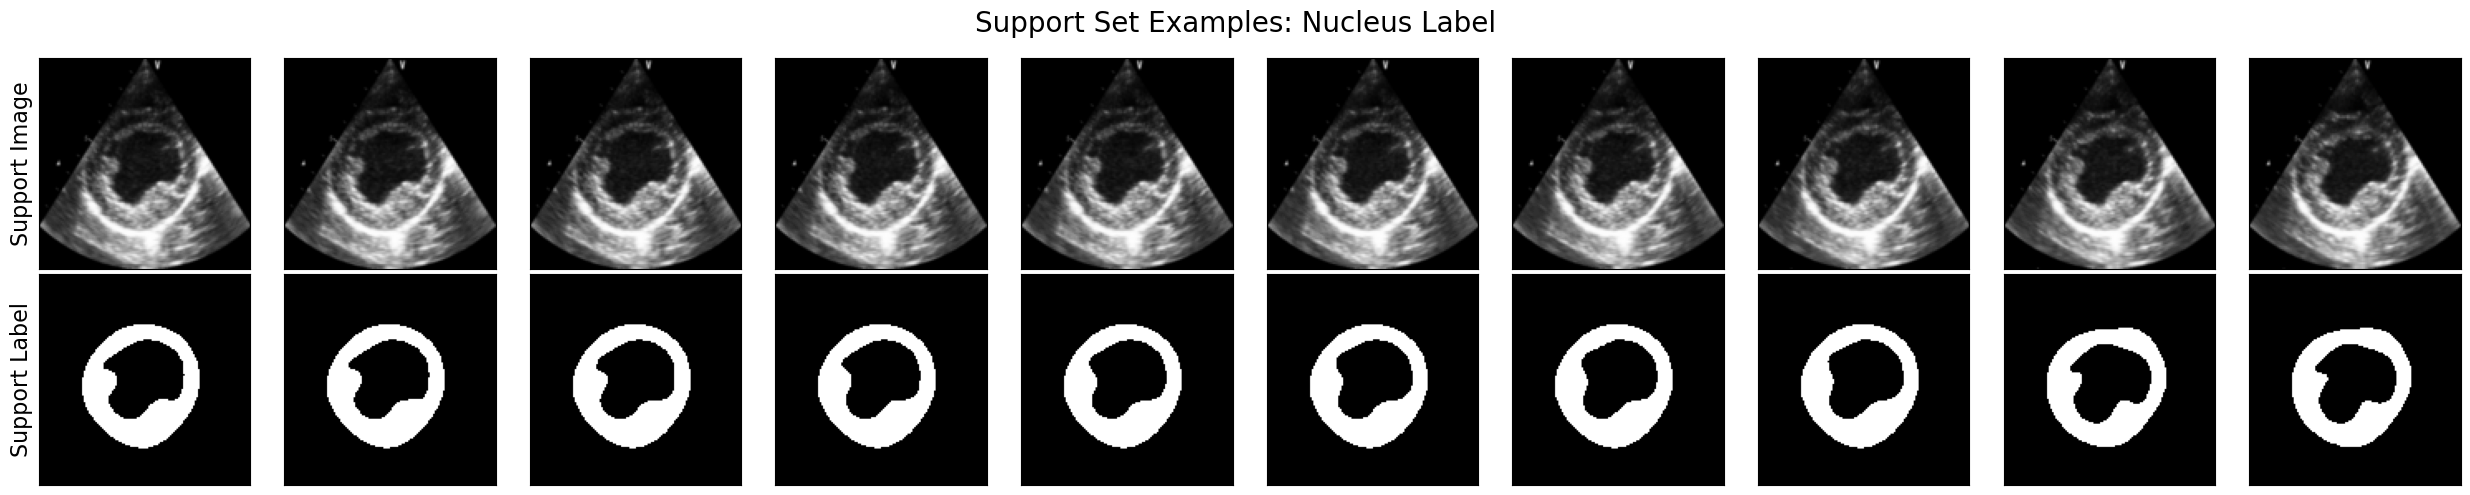

In [62]:
#LABEL IS NOT CHANGED
n_viz = 10
visualize_tensors({
    'Support Image': support_images[:n_viz],
    'Support Label': support_labels[:n_viz],
}, col_wrap=10, title='Support Set Examples: ... Label')

  0%|          | 0/10 [00:00<?, ?it/s]

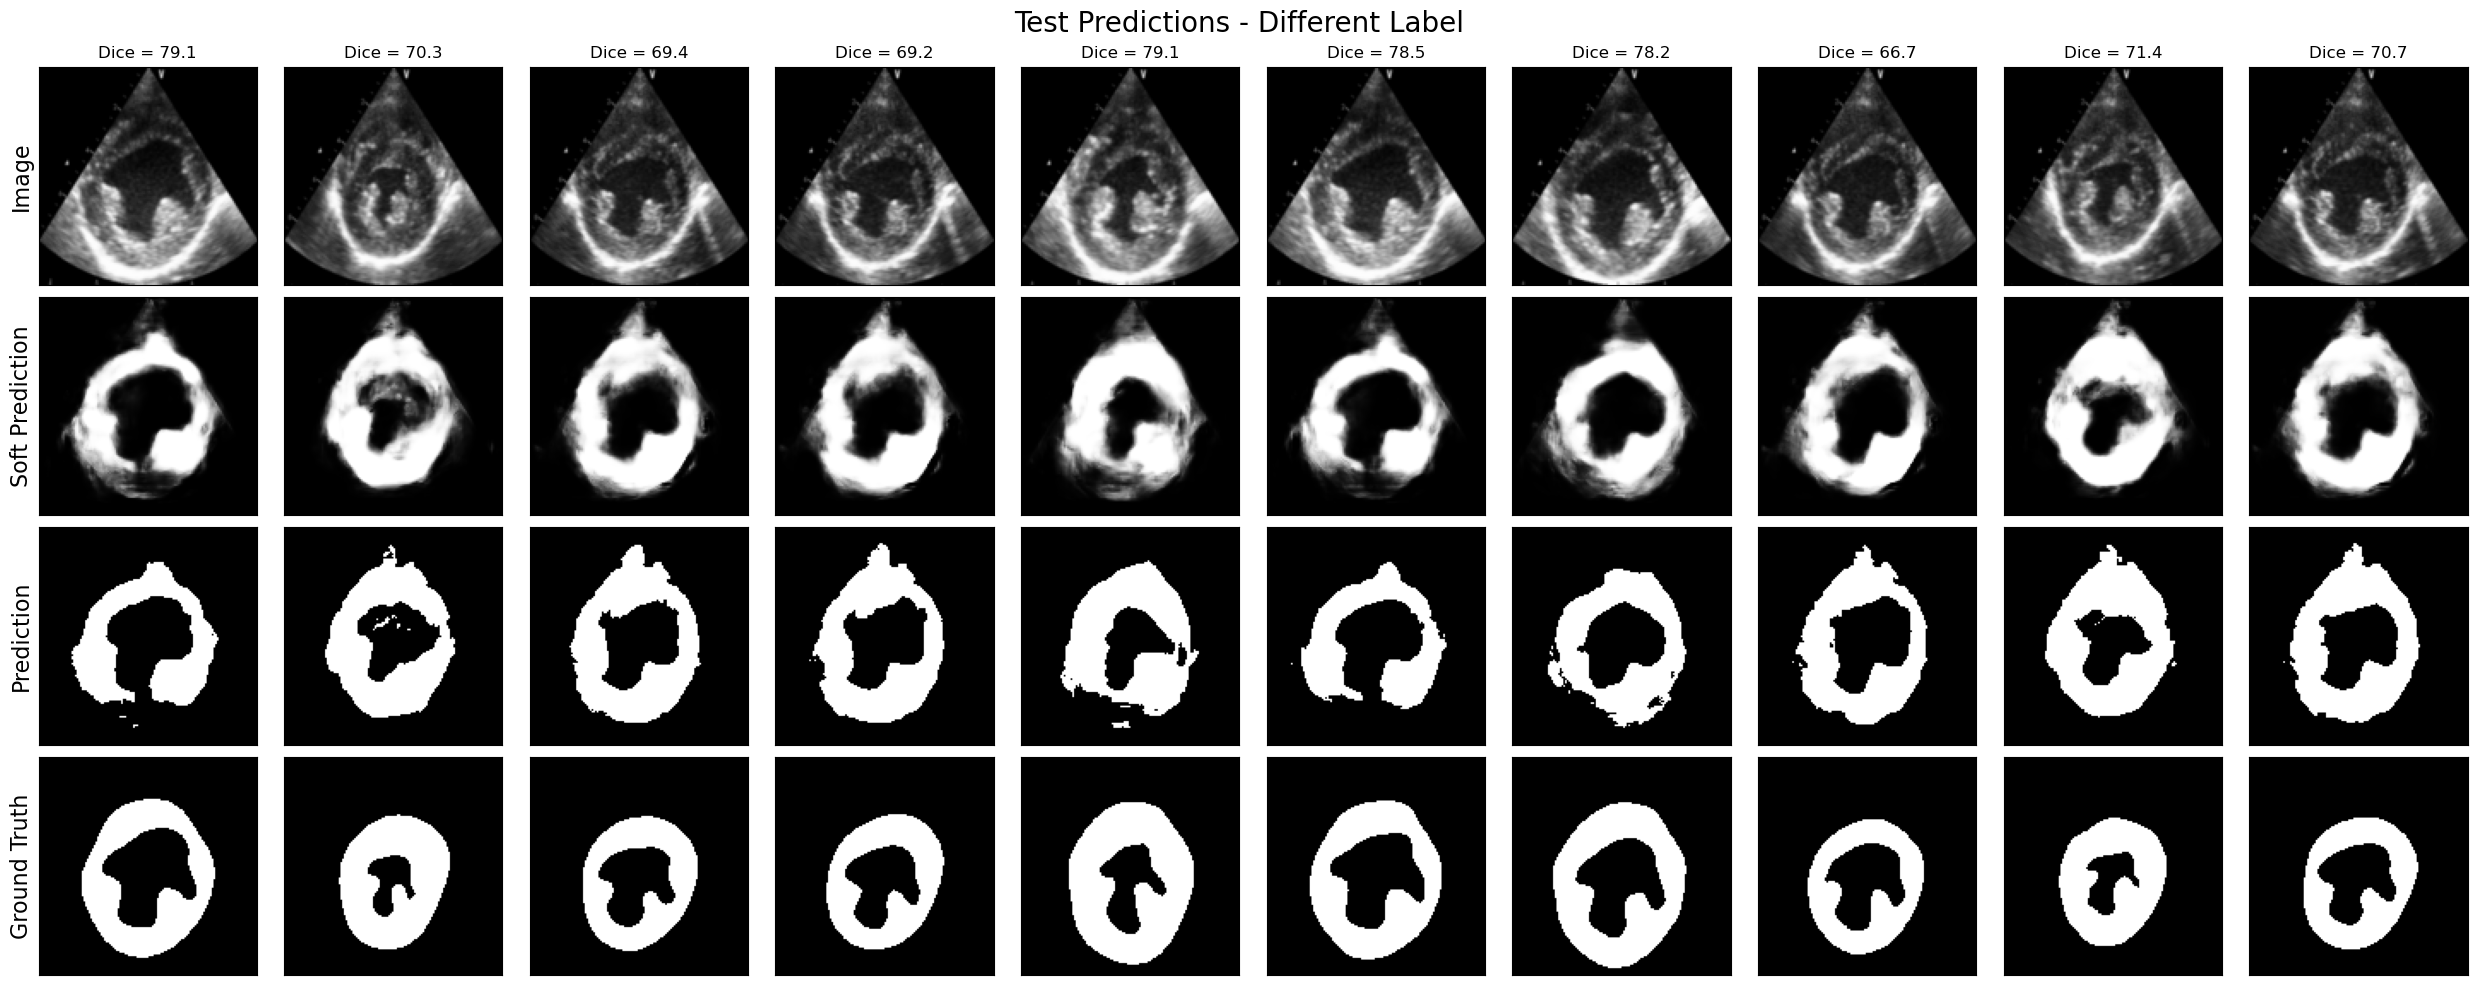

In [63]:
#compute 10 predictions and visualize
n_predictions = 10

results = defaultdict(list)

idxs = np.random.permutation(len(d_test))[:n_predictions]
for i in tqdm(idxs):
    image, label = d_test[i]
    vals = inference(model, image, label, support_images, support_labels)
    for k, v in vals.items():
        results[k].append(v)

scores = results.pop('score')
visualize_tensors(results, col_names=[f'Dice = {100*s:.1f}' for s in scores], title='Test Predictions - Different Label', col_wrap=n_predictions)

In [ ]:
#INVERTING THE IMAGE

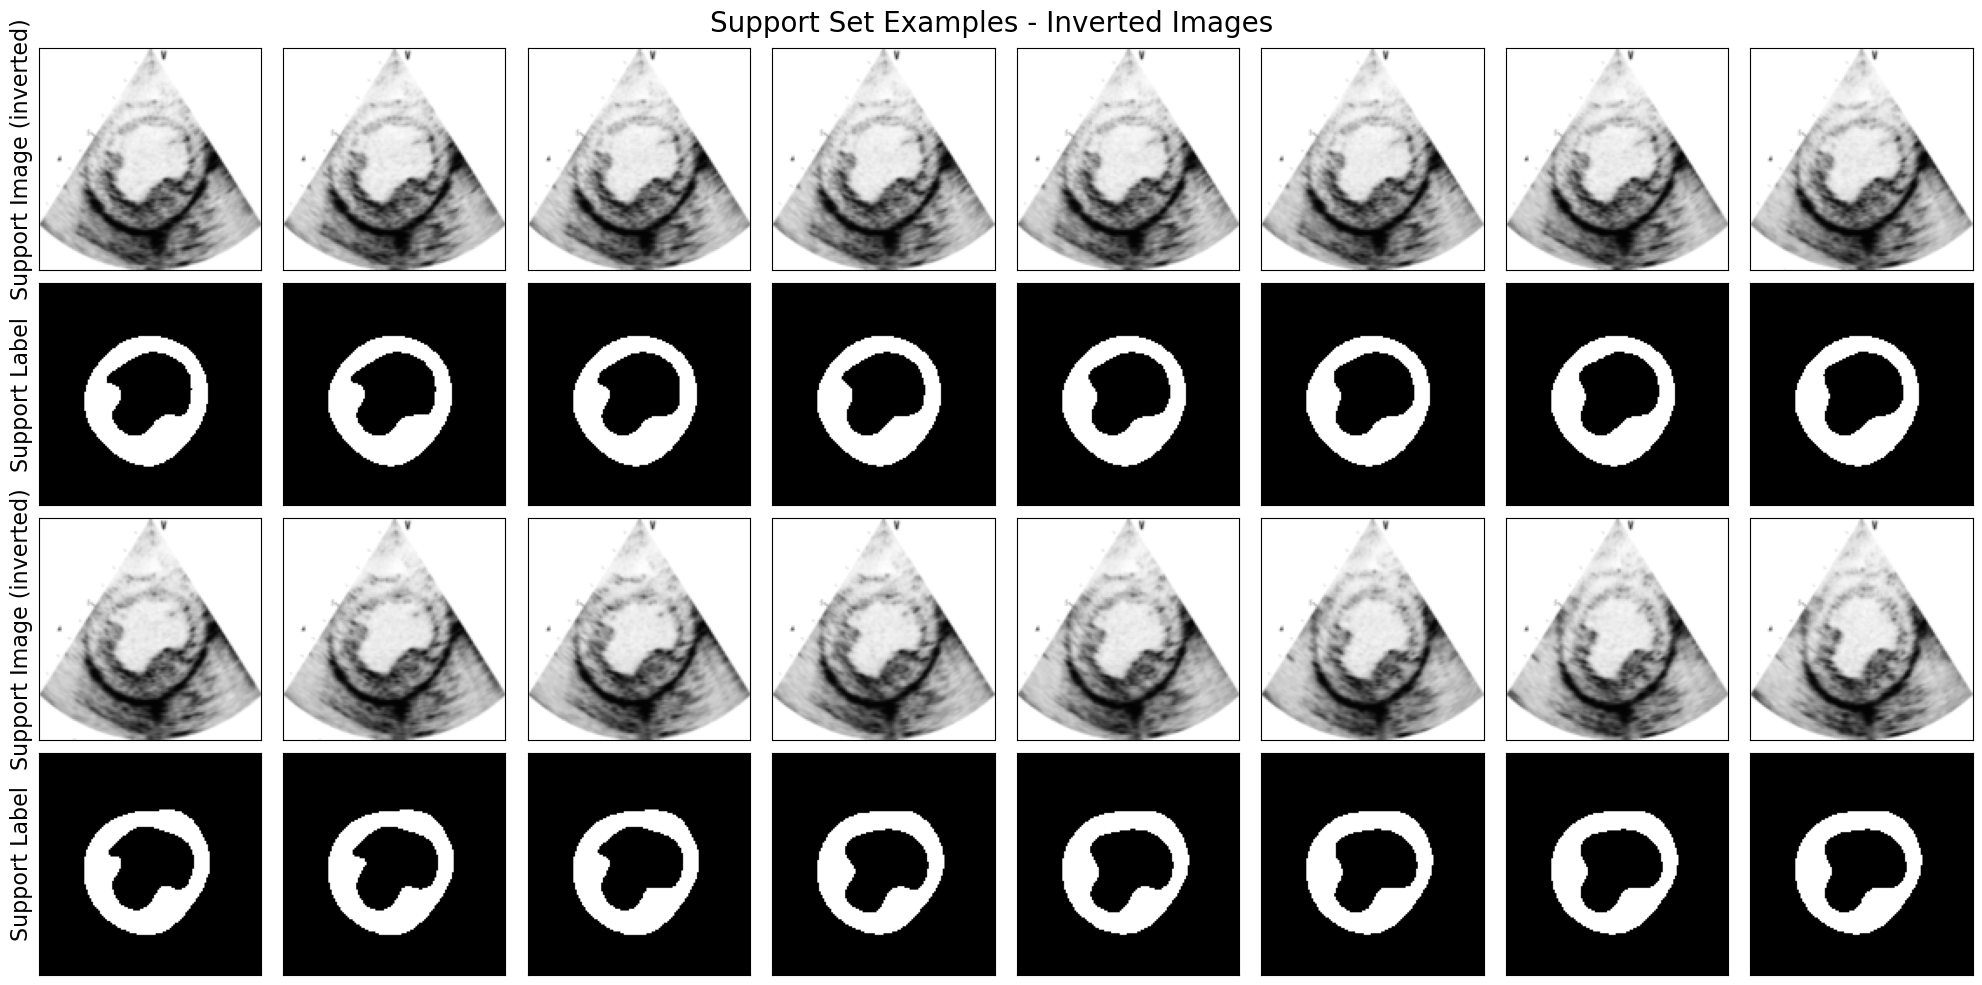

In [64]:
n_support = 64

support_images, support_labels = zip(*itertools.islice(d_support, n_support))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)

# invert images by intensity
support_images = 1 - support_images

# visualize support set
n_viz = 16
visualize_tensors({
    'Support Image (inverted)': support_images[:n_viz],
    'Support Label': support_labels[:n_viz],
}, 8,  title='Support Set Examples - Inverted Images')

  0%|          | 0/10 [00:00<?, ?it/s]

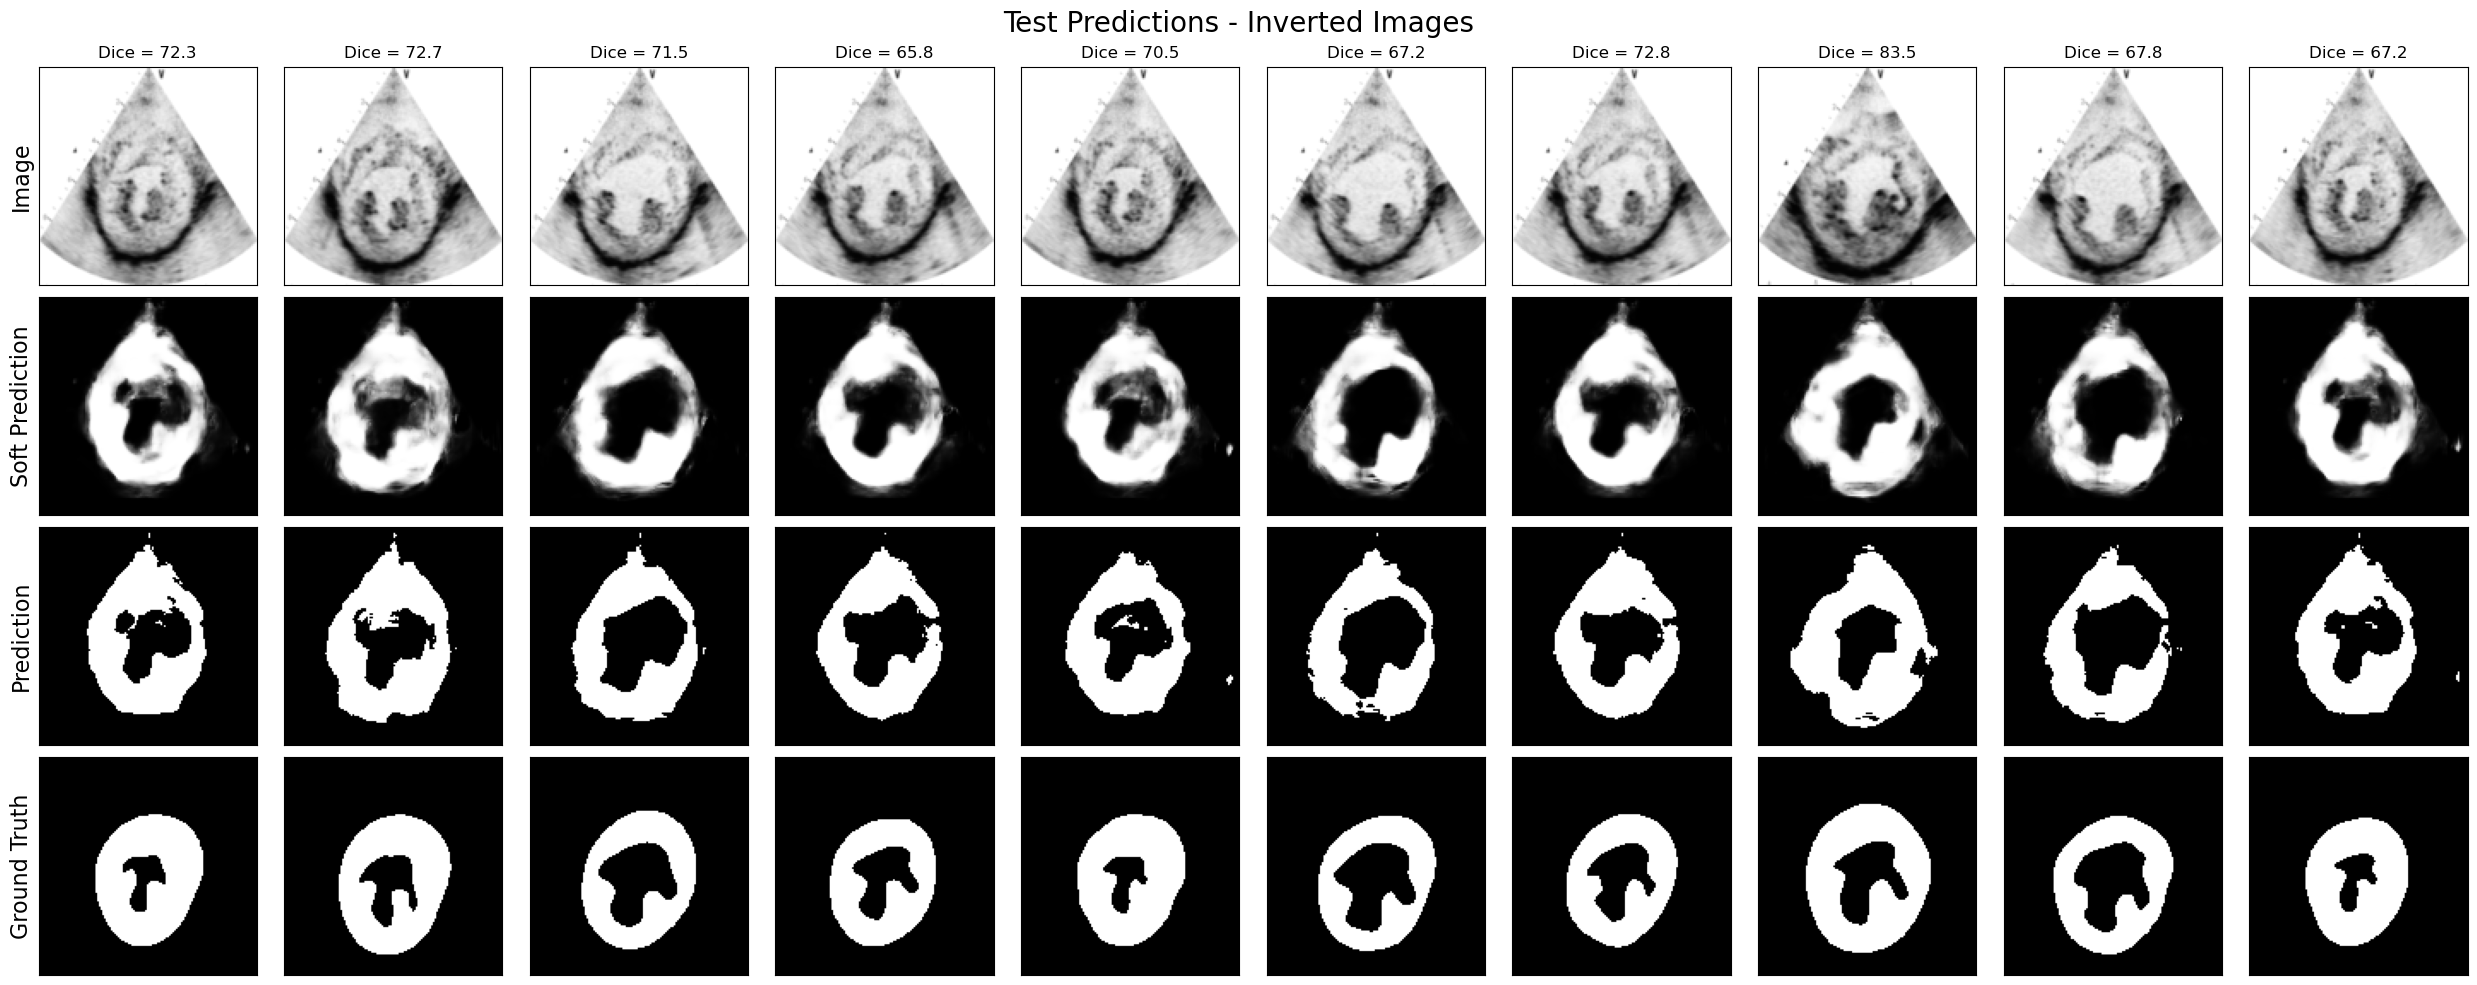

In [65]:
n_predictions = 10

results = defaultdict(list)
idxs = np.random.permutation(len(d_test))[:n_predictions]

for i in tqdm(idxs):
    image, label = d_test[i]
    vals = inference(model, 1-image, label, support_images, support_labels)
    for k, v in vals.items():
        results[k].append(v)

scores = results.pop('score')
visualize_tensors(results, col_names=[f'Dice = {100*s:.1f}' for s in scores], title='Test Predictions - Inverted Images', col_wrap=n_predictions)

### Effect of support set size

In [66]:
n_support = 64

support_images, support_labels = zip(*itertools.islice(d_support, n_support))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)


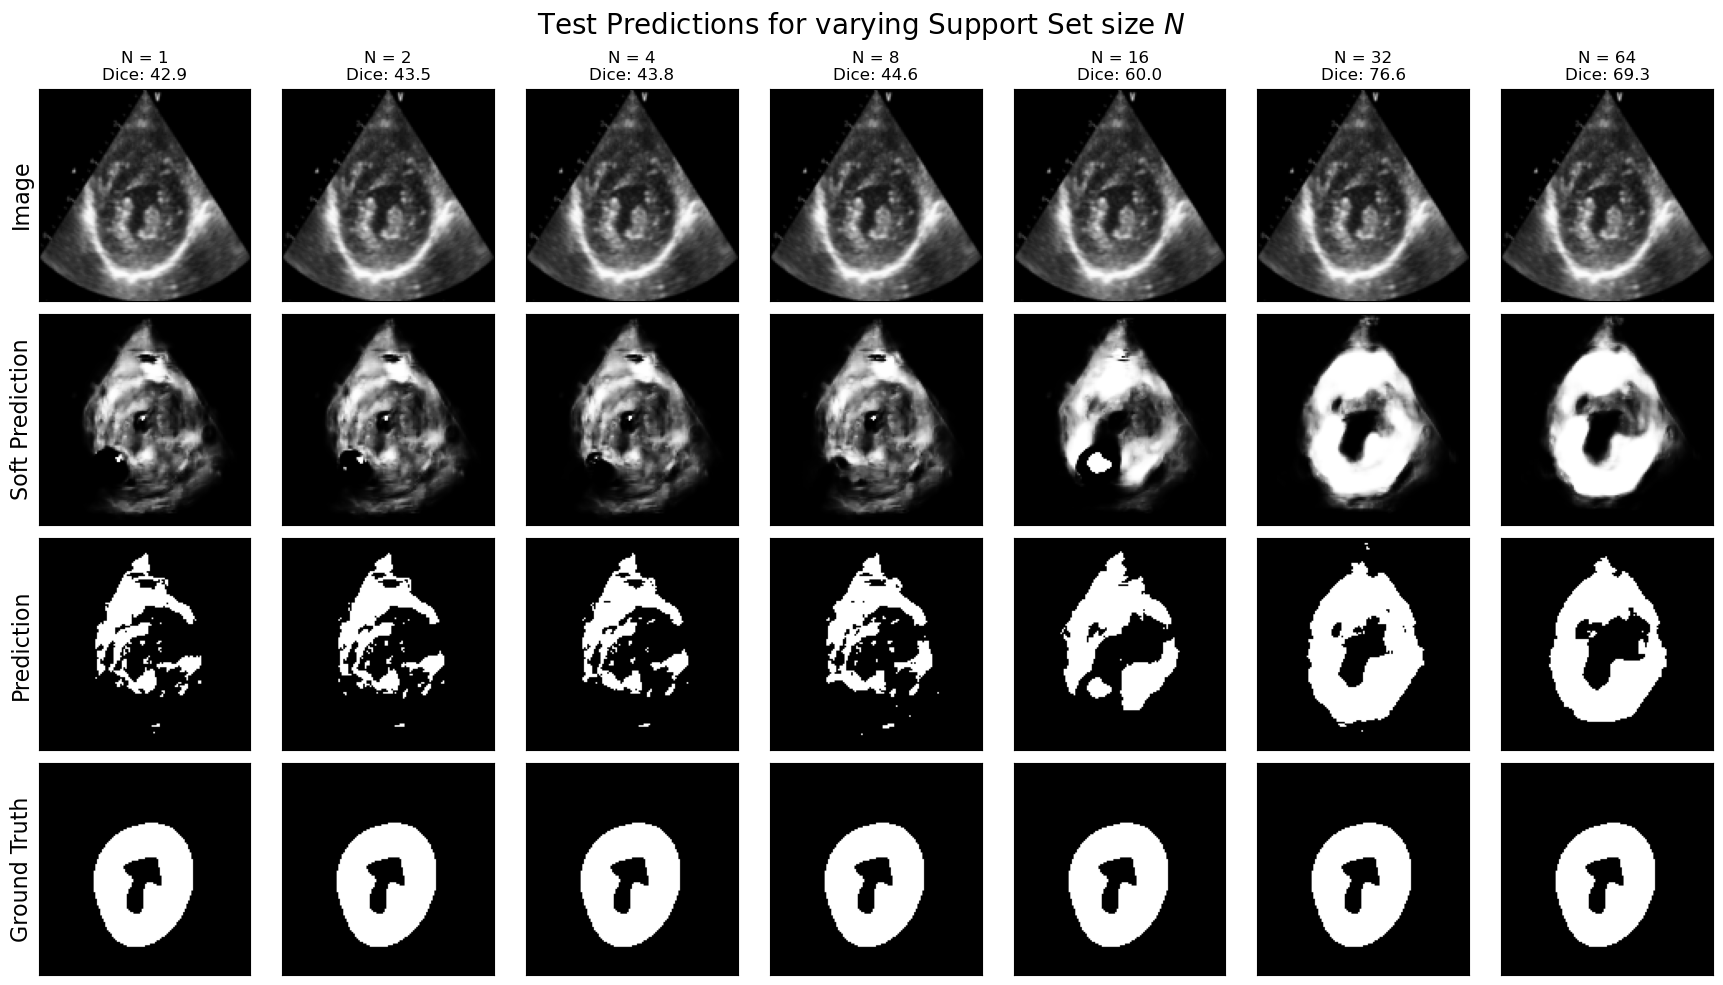

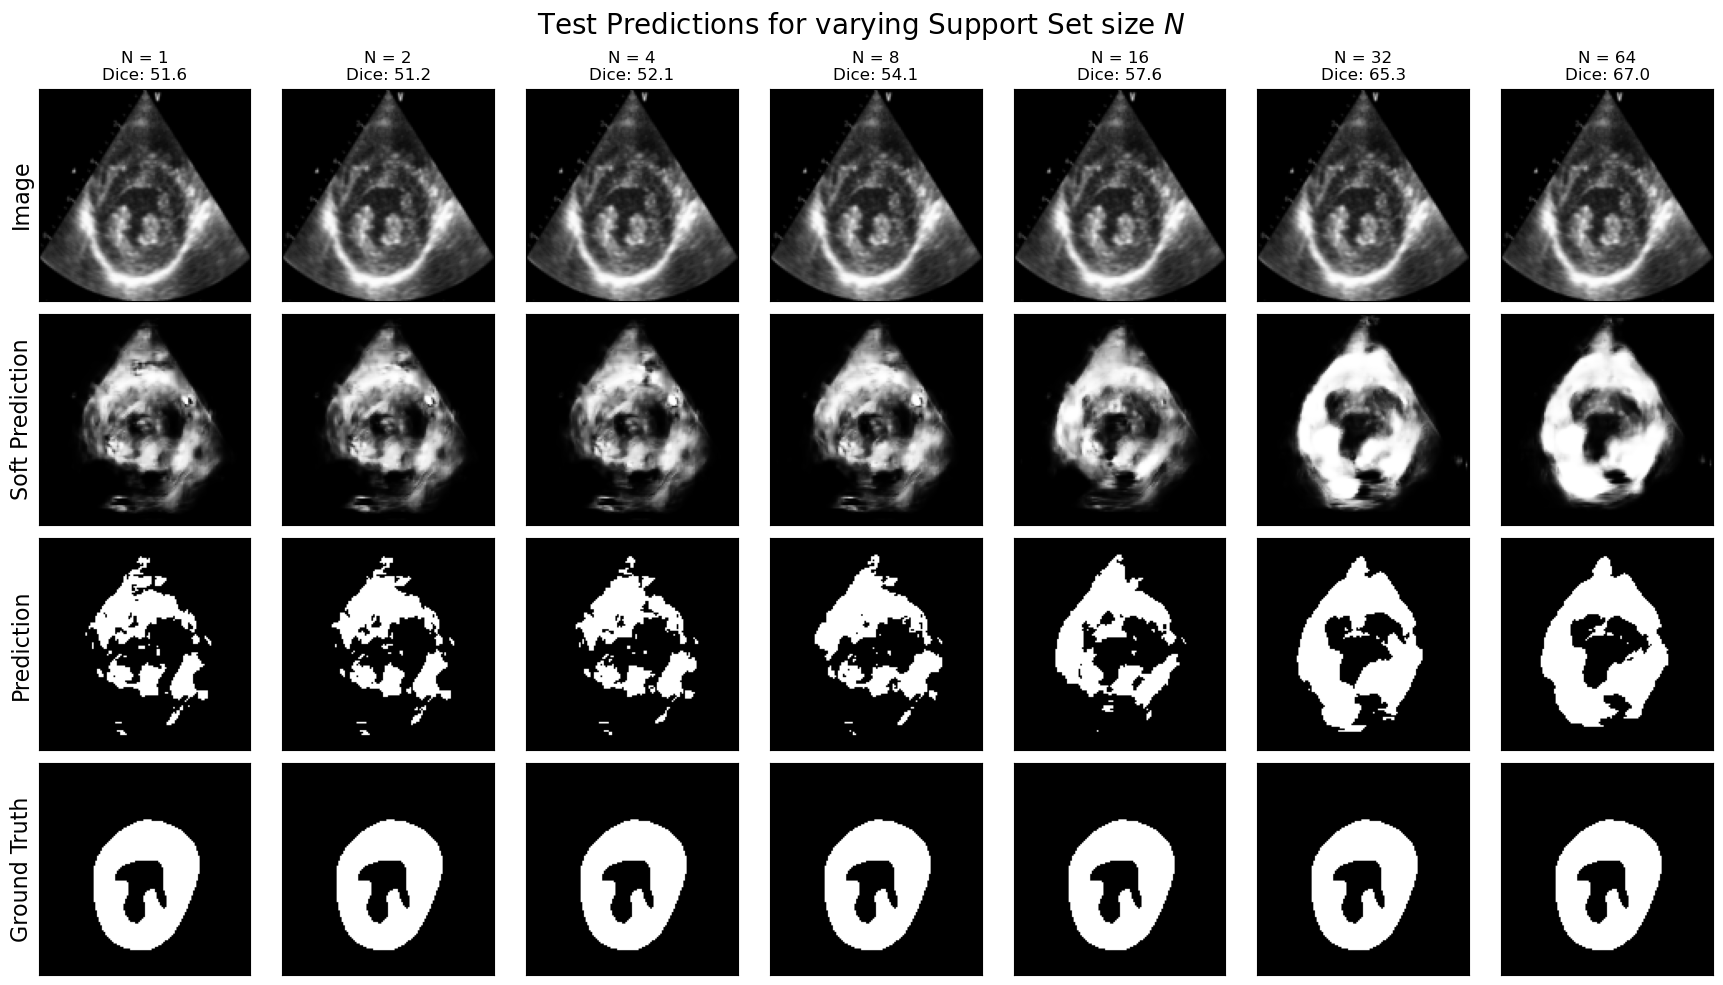

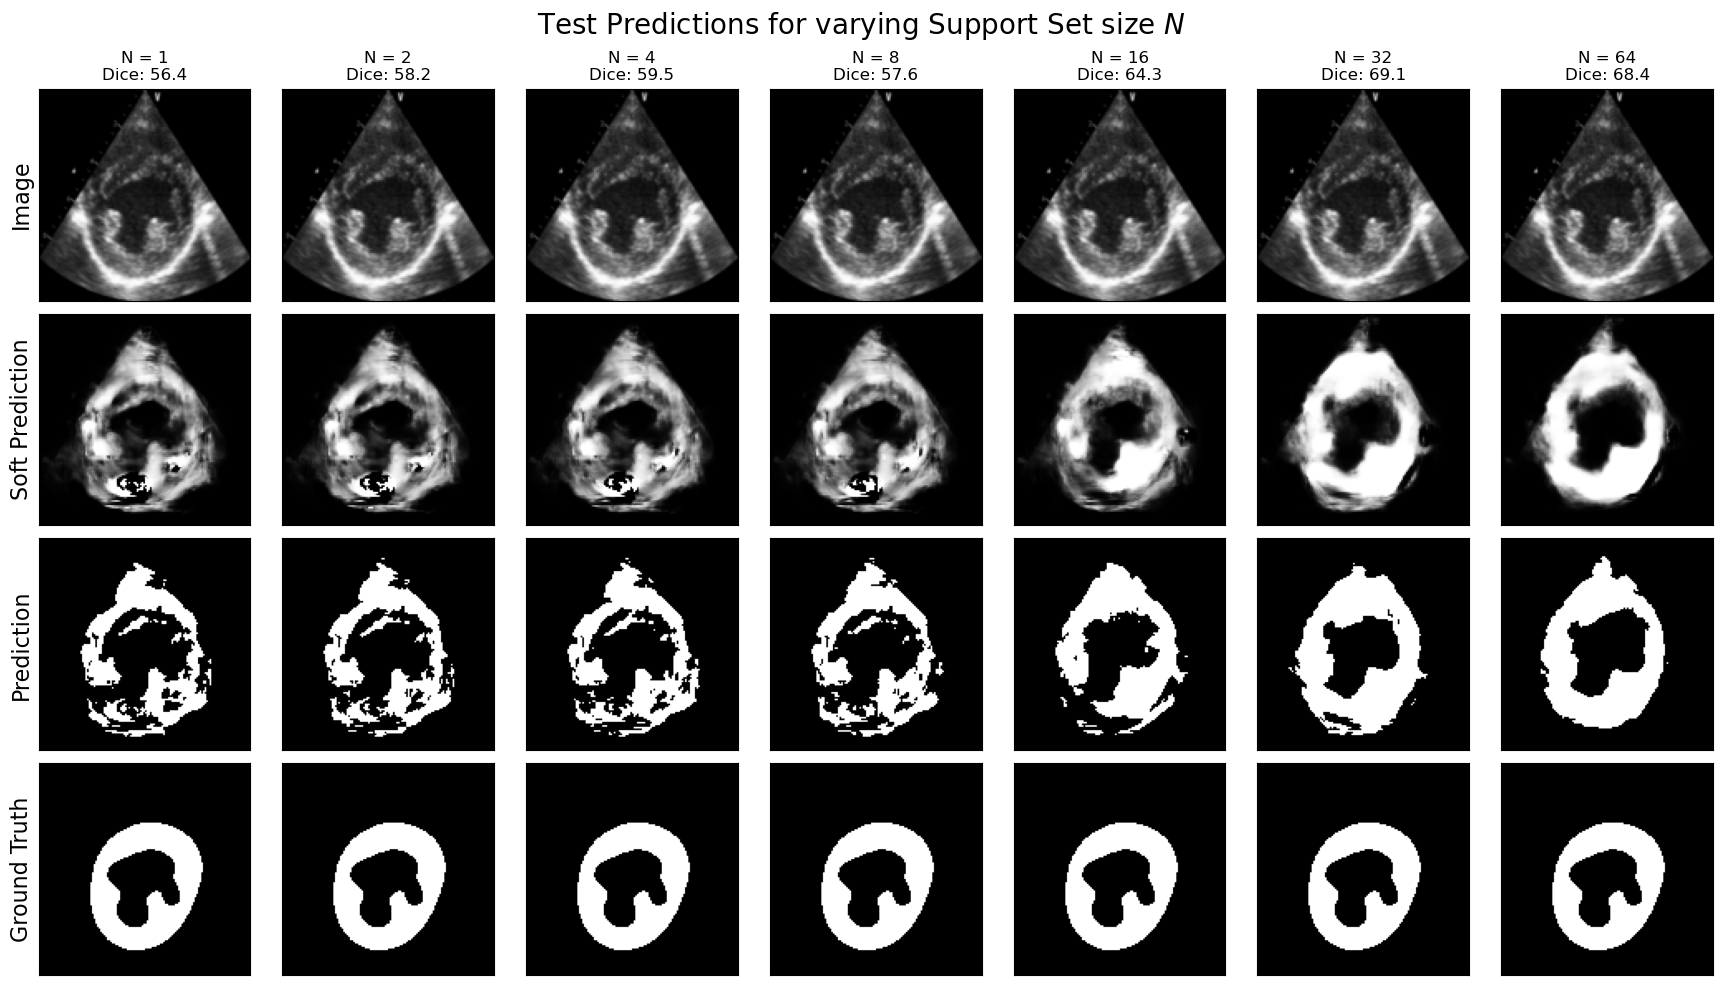

In [76]:
n_predictions = 3
support_set_sizes = [1, 2, 4, 8, 16, 32, 64]

idxs = np.random.permutation(len(d_test))[:n_predictions]

for i in idxs:
    results = defaultdict(list)
    for N in support_set_sizes:
        image, label = d_test[i]
        vals = inference(model, image, label, support_images[:N], support_labels[:N])
        for k, v in vals.items():
            results[k].append(v)

    # visualize for this entry for different support sizes
    scores = results.pop('score')
    col_names = [f'N = {N}' for N in support_set_sizes]
    col_names = [col+f'\nDice: {100*score:.1f}' for col, score in zip(col_names, scores)]
    visualize_tensors(results, col_names=col_names, title='Test Predictions for varying Support Set size $N$', col_wrap=len(support_set_sizes))

### Creating the average metric scores per support set(N)

In [87]:
@torch.no_grad()
def inferencesupport(model, image, label, support_images, support_labels):
    image, label = image.to(device), label.to(device)

    # inference
    logits = model(
        image[None],
        support_images[None],
        support_labels[None]
    )[0] # outputs are logits

    soft_pred = torch.sigmoid(logits)
    hard_pred = soft_pred.round().clip(0,1)

    #  score
    dicescore = dice_score(hard_pred, label)
    accuracy = accuracy_score(hard_pred,label)
    sensitivity =sensitivity_score(hard_pred,label)
    precision=precision_score(hard_pred,label)
    jaccard=jaccard_score(hard_pred,label)

    # return a dictionary of all relevant variables
    return {'Image': image,
            'Soft Prediction': soft_pred,
            'Prediction': hard_pred,
            'Ground Truth': label,
            'score': dicescore,
            'accuracy' : accuracy,
            'sensitivity':sensitivity,
            'precision':precision,
            'jaccard' : jaccard}

In [79]:
support_images, support_labels = zip(*itertools.islice(d_support, n_support))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)
support_set_sizes = [1, 2, 4, 8, 16, 32, 64]
avg_dice_scores = defaultdict(float)
count_per_size = defaultdict(int)

total_samples = len(d_test)
for i in range(total_samples):
    results = defaultdict(list)
    for N in support_set_sizes:
        vals = inference(model, image, label, support_images[:N], support_labels[:N])
        for k, v in vals.items():
            results[k].append(v)

    scores = results.pop('score')
    for i, N in enumerate(support_set_sizes):
        avg_dice_scores[N] += scores[i]
        count_per_size[N] += 1

for N in support_set_sizes:
    avg_dice_scores[N] /= count_per_size[N] if count_per_size[N] != 0 else 1

avg_dice_scores


defaultdict(float,
            {1: 0.564406156539917,
             2: 0.5821881294250488,
             4: 0.5953423380851746,
             8: 0.5763425827026367,
             16: 0.6427165269851685,
             32: 0.6913946866989136,
             64: 0.6843492984771729})

In [91]:
import pandas as pd

support_images, support_labels = zip(*itertools.islice(d_support, n_support))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)
support_set_sizes = [1, 2, 4, 8, 16, 32, 64]

# Create empty DataFrames for each metric
df_dicescore = pd.DataFrame(columns=support_set_sizes)
df_accuracy= pd.DataFrame(columns=support_set_sizes)
df_sensitivity=pd.DataFrame(columns=support_set_sizes)
df_precision=pd.DataFrame(columns=support_set_sizes)
df_jaccard=pd.DataFrame(columns=support_set_sizes)

for image, label in d_test:
    dice_scores = {}
    acc={}
    sens={}
    prec={}
    jac={}
    for N in support_set_sizes:
        vals = inferencesupport(model, image, label, support_images[:N], support_labels[:N])
        dice_scores[N] = vals['score'] if 'score' in vals else None
        acc[N] = vals['accuracy'] if 'accuracy' in vals else None
        sens[N] = vals['sensitivity'] if 'sensitivity' in vals else None
        prec[N] = vals['precision'] if 'precision' in vals else None
        jac[N] = vals['jaccard'] if 'jaccard' in vals else None

    # Append the dice scores for this image to the DataFrames
    df_dicescore = pd.concat([df_dicescore, pd.DataFrame(dice_scores, index=[0])], ignore_index=True)
    df_accuracy = pd.concat([df_accuracy, pd.DataFrame(acc, index=[0])], ignore_index=True)
    df_sensitivity = pd.concat([df_sensitivity, pd.DataFrame(sens, index=[0])], ignore_index=True)
    df_precision = pd.concat([df_precision, pd.DataFrame(prec, index=[0])], ignore_index=True)
    df_jaccard = pd.concat([df_jaccard, pd.DataFrame(jac, index=[0])], ignore_index=True)



In [94]:
df_dicescore.to_csv('baseline_dicescore.csv', index=False)
df_accuracy.to_csv('baseline_accuracy.csv', index=False)
df_sensitivity.to_csv('baseline_sensitivity.csv', index=False)
df_precision.to_csv('baseline_precision.csv', index=False)
df_jaccard.to_csv('baseline_jaccard.csv', index=False)

In [103]:
meandice_df = pd.DataFrame(df_dicescore.mean().to_dict(),index=['DiceScore'])
meanacc_df = pd.DataFrame(df_accuracy.mean().to_dict(),index=['Accuracy'])
meansens_df=pd.DataFrame(df_sensitivity.mean().to_dict(),index=['Sensitivity'])
meanprec_df= pd.DataFrame(df_precision.mean().to_dict(),index=['Precision'])
meanjac_df = pd.DataFrame(df_jaccard.mean().to_dict(),index=['Jaccard'])

In [107]:
df=[meandice_df,meanacc_df,meansens_df,meanprec_df,meanjac_df]
result=pd.concat(df)
result

1         2         4         8         16        32  \
DiceScore    0.551958  0.557279  0.563575  0.573367  0.670572  0.730020   
Accuracy     0.849382  0.850744  0.851927  0.852400  0.872480  0.884639   
Sensitivity  0.492351  0.498526  0.507445  0.525215  0.686616  0.823676   
Precision    0.654270  0.657761  0.659526  0.653130  0.669282  0.665738   
Jaccard      0.384419  0.389559  0.395620  0.405427  0.508179  0.577076   

                   64  
DiceScore    0.720834  
Accuracy     0.883032  
Sensitivity  0.799039  
Precision    0.664290  
Jaccard      0.566543

### Multilabel

### Ensembling predictions

In [68]:
# helpful function to sample support data
def sample_support(seed):
    rng = np.random.default_rng(seed)
    idxs = rng.integers(0,len(d_support), size=support_size)
    support_images, support_labels = zip(*[d_support[i] for i in idxs])
    support_images = torch.stack(support_images).to(device)
    support_labels = torch.stack(support_labels).to(device)
    return support_images, support_labels

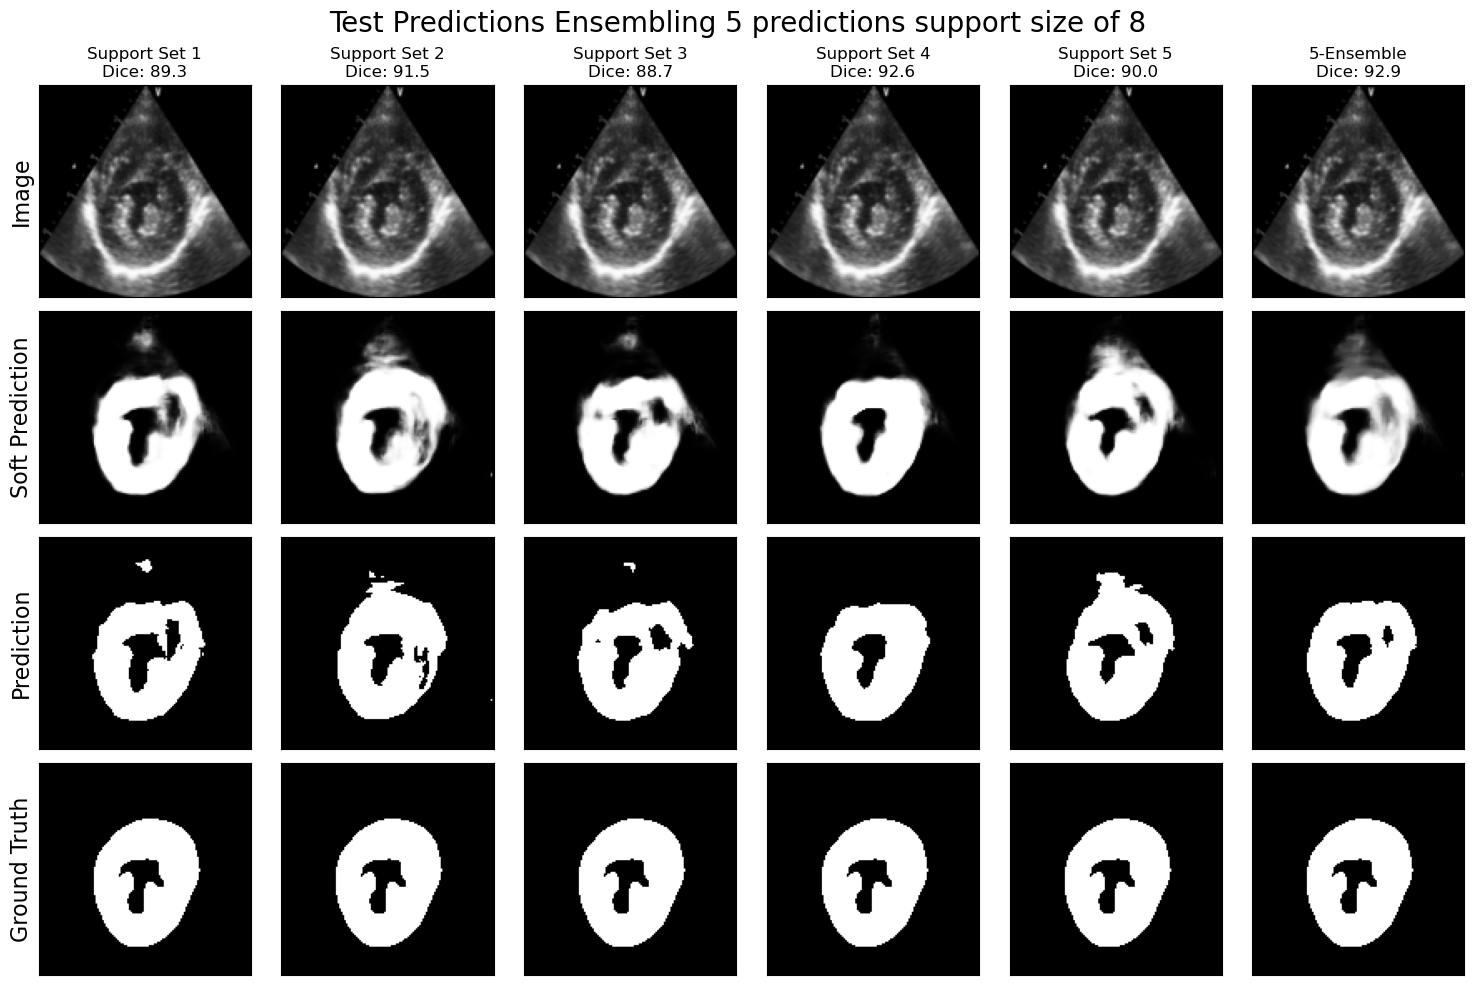

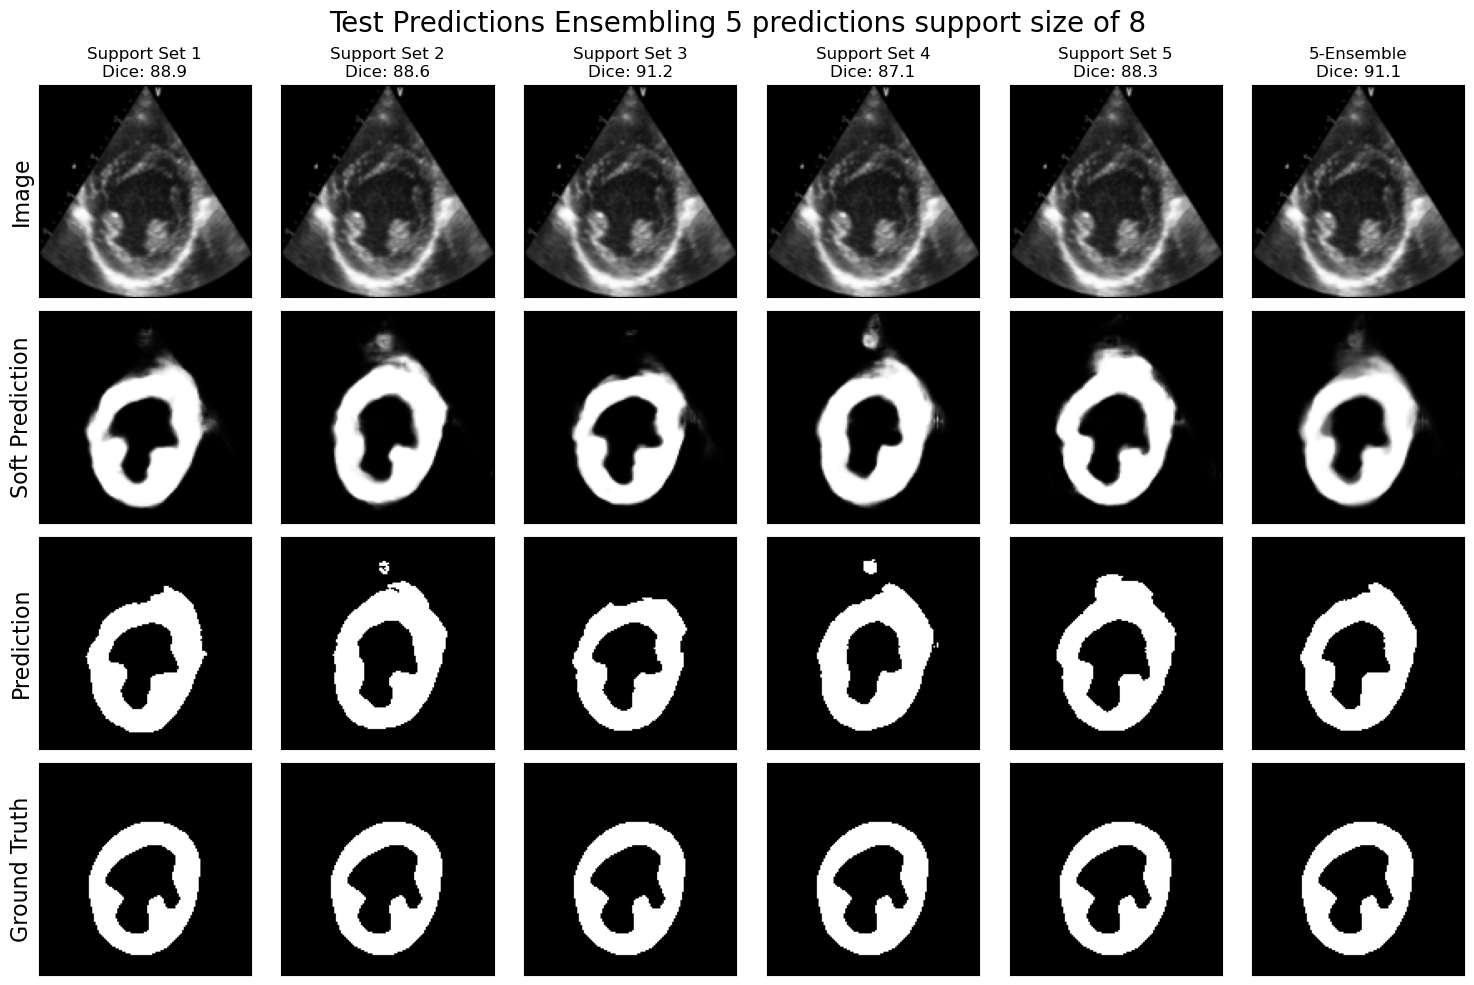

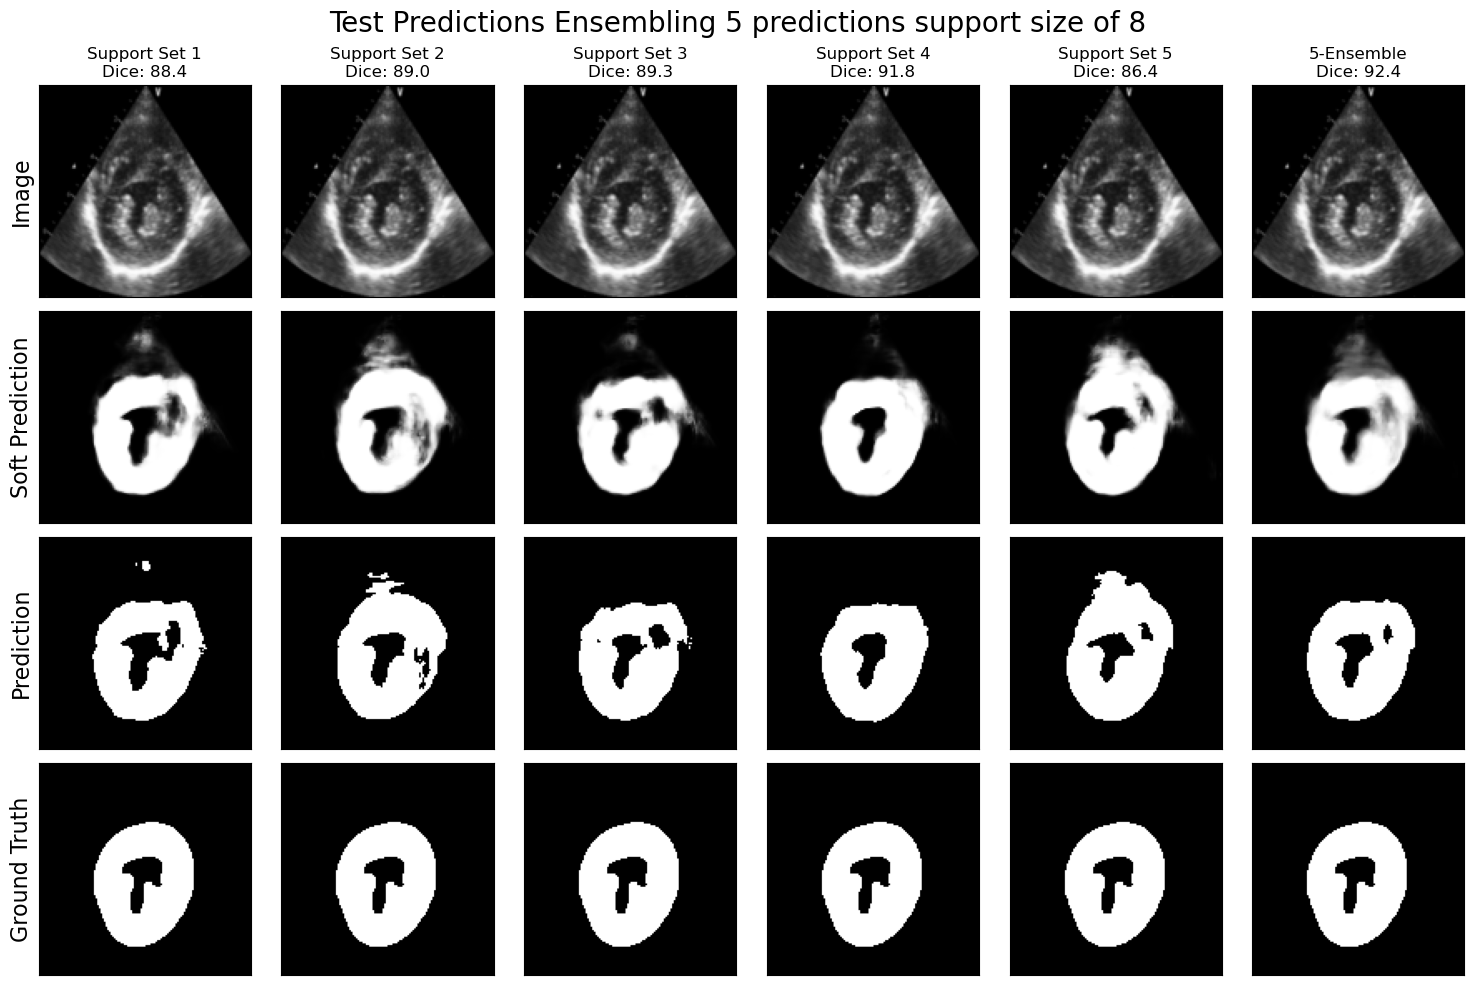

In [69]:
d_support = VentricleDataset(support_input_folder, label=support_output_pap_folder)
d_test = VentricleDataset(test_input_folder, label=test_output_pap_folder)


# setup the number of predictions and ensembling
support_size = 8
n_predictions = 3
n_ensemble = 5

# get various support sets
idxs = np.random.permutation(len(d_test))[:n_predictions]
seeds = range(n_ensemble)
supports = {
    seed: sample_support(seed)
    for seed in range(n_ensemble)
}

# go through the number of experiments
for i in idxs:

    # go through the number of predictions we will ensemble
    results = defaultdict(list)
    for j in range(n_ensemble):
        # get support set and query
        support_images, support_labels = sample_support(j)
        image, label = d_test[i]

        # perform inference
        vals = inference(model, image, label, support_images, support_labels)
        for k, v in vals.items():
            results[k].append(v)

    results['Image'].append(image)
    ensemble = torch.mean(torch.stack(results['Soft Prediction']), dim=0)
    results['Soft Prediction'].append(ensemble)
    results['Prediction'].append(ensemble.round())
    results['Ground Truth'].append(label)
    results['score'].append(dice_score(ensemble.round(), label.to(device)))

    scores = results.pop('score')
    col_names = [f'Support Set {i+1}' for i in range(n_ensemble)] + [f'{n_ensemble}-Ensemble']
    col_names = [col+f'\nDice: {100*score:.1f}' for col, score in zip(col_names, scores)]

    visualize_tensors(results,
                      col_names=col_names,
                      title=f'Test Predictions Ensembling {n_ensemble} predictions support size of {support_size}',
                      col_wrap=n_ensemble+1)